In [1]:
import numpy as np
import scipy.fftpack
from scipy import ndimage
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import os
from SBR import sosf,acf,ps,sosfnorm

input_file='datosNGC604r.txt'

data_0=pd.read_table(input_file)
data=data_0.copy()
data_2=(data.round(2)).pivot(index='DE', columns='RA', values='Halpha')

In [2]:
data.describe()

,RA,DE,Halpha,RVHalpha,SigmHalpha,[NII]6548,RV[NII]6548,Sigm[NII]6548,[NII]6584,RV[NII]6584,Sigm[NII]6584,[SII]6717,RV[SII]6717,Sigm[SII]6717,[SII]6731,RV[SII]6731,Sigm[SII]6731
count,1500.000000,1500.000000,1497.000000,1500.000000,1500.000000,1.497000e+03,1500.000000,1500.000000,1.497000e+03,1500.000000,1500.000000,1475.000000,1500.000000,1500.000000,1.475000e+03,1500.000000,1500.000000
mean,99.904500,9.390000,920.352503,-806.416087,83.475644,2.674423e+03,-834.243945,74.894615,8.020595e+03,-810.271697,74.452375,105.036422,-5215.925607,47.840685,1.958644e+12,-5241.719214,47.702254
std,58.085078,6.252917,2624.750671,13389.980282,348.636537,9.772014e+04,13388.255744,252.553948,2.930571e+05,13389.322780,251.221405,218.638500,38363.413828,281.044179,7.522315e+13,38360.054292,280.421940
min,0.000000,0.000000,-5108.000000,-299792.000000,0.000000,-6.668000e+01,-299792.000000,0.000000,-2.000000e+02,-299792.000000,0.000000,-695.300000,-299792.000000,0.000000,-6.323000e+05,-299792.000000,0.000000
25%,49.617000,4.000000,-14.620000,-277.337749,8.578435,3.071000e+00,-287.407495,10.154780,9.214000e+00,-263.109263,10.021200,2.705500,-244.585366,0.000000,1.754000e+00,-270.763708,0.000000
50%,99.904500,9.000000,47.630000,-267.002536,16.510678,6.889000e+00,-276.282044,17.402472,2.067000e+01,-252.042963,17.263627,16.630000,-232.611095,12.111469,1.180000e+01,-258.816121,12.042395
75%,150.192000,15.000000,615.400000,-152.241694,50.274305,4.467000e+01,-219.693328,74.357319,1.340000e+02,-195.755113,73.951154,119.450000,-215.057014,29.091392,8.495000e+01,-241.301160,29.009066
max,199.809000,19.600000,30960.000000,2589.901754,5770.228814,3.778000e+06,874.378072,6480.291011,1.133000e+07,892.499410,6445.836962,2329.000000,533.786887,5542.682685,2.889000e+15,505.873947,5530.330752


Here we use the Halpha line as reference to distinguish between useful and non-useful data

(0.0, 150.0, 0.0, 10.0)

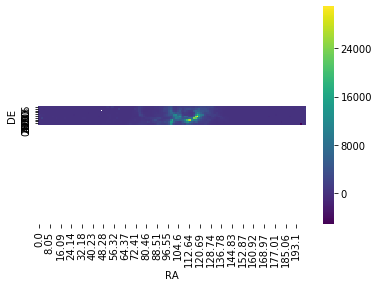

In [3]:
sns.heatmap(data_2, cmap="viridis")
plt.gca().invert_yaxis()
plt.axis('equal')

/home/zalenovo/my_project_dir/my_project_env/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-9.99564490057674, 209.80464490057673, -0.987998770755577, 20.58799877075558)

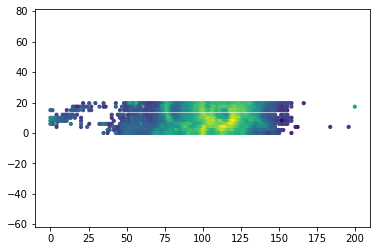

In [4]:
plt.scatter(data.RA,data.DE,c=np.log10(data.Halpha), s=10)
plt.axis('equal')

As supposed some data values cant be used

Here we applpy a filter on Coordinates based on the previous images
Between 60 arcsec and 145 arcsec in x coordinate.

In [5]:
m=(data.RA<145)&(data.RA>65)
dataH=data[m]
dataH.describe()

,RA,DE,Halpha,RVHalpha,SigmHalpha,[NII]6548,RV[NII]6548,Sigm[NII]6548,[NII]6584,RV[NII]6584,Sigm[NII]6584,[SII]6717,RV[SII]6717,Sigm[SII]6717,[SII]6731,RV[SII]6731,Sigm[SII]6731
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,105.268500,9.390000,2277.239467,-275.723172,13.935739,111.115387,-274.862061,21.256333,333.340168,-250.630529,21.078784,236.622155,-229.809584,23.307849,168.994135,-256.025456,23.203230
std,23.242952,6.256047,3750.107456,10.420076,7.810655,146.904445,31.103744,33.677958,440.691257,30.938373,33.515867,256.953154,26.830756,208.758950,201.362479,26.770974,208.297516
min,65.709000,0.000000,27.150000,-303.272854,0.000000,2.470000,-321.722417,0.000000,7.410000,-297.241741,0.000000,-25.030000,-337.288319,0.000000,-1343.000000,-363.260073,0.000000
25%,85.488750,4.000000,281.925000,-283.516037,9.420592,21.910000,-286.617726,10.253717,65.727500,-262.323693,10.120385,58.370000,-240.300072,5.044214,40.177500,-266.487964,4.931070
50%,105.268500,9.000000,1017.500000,-275.567630,12.706963,64.105000,-279.578474,13.519989,192.300000,-255.321867,13.388430,160.850000,-233.392268,10.194938,113.600000,-259.595554,10.122188
75%,125.048250,15.000000,2403.500000,-269.697685,16.901530,137.950000,-271.829574,18.615067,413.950000,-247.614166,18.472799,325.000000,-226.495624,16.456006,231.750000,-252.714278,16.388386
max,144.828000,19.600000,30960.000000,-231.143341,60.414211,1298.000000,-8.653129,254.436545,3893.000000,14.163043,253.080612,2137.000000,45.665160,5029.368305,1568.000000,18.839996,5018.160282


Statistical emission data for all lines

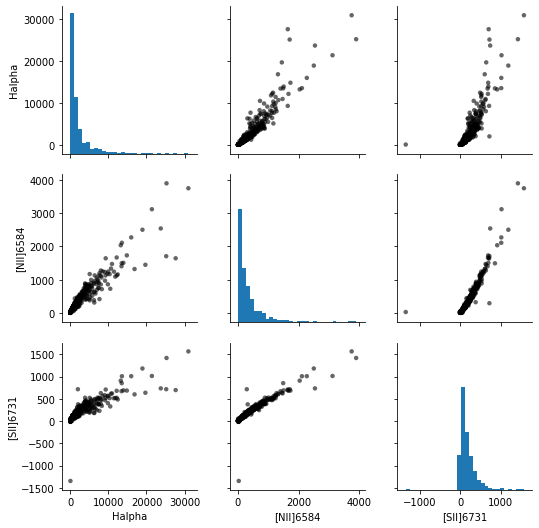

In [6]:
sns.pairplot(dataH,
             vars=["Halpha", "[NII]6584", "[SII]6731"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.6, s=20, edgecolor='none', color='k'),
             diag_kws=dict(bins=30),
            )

Data looks better, still adjusments will be done individually for each line.

Halpha emission line analysis

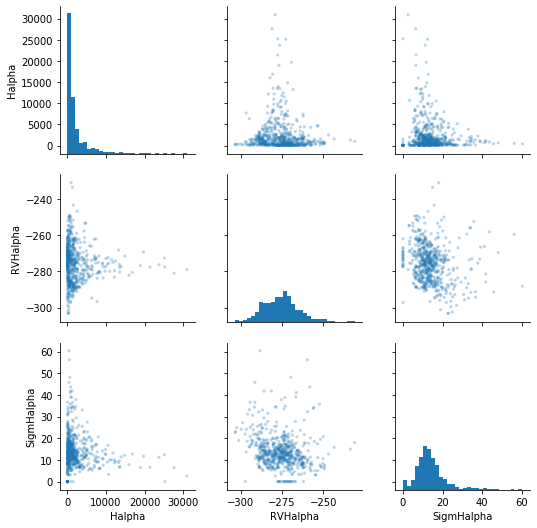

In [7]:
sns.pairplot(dataH,
             vars=["Halpha", "RVHalpha", "SigmHalpha"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

Data looks good, still sigma presents some weird values towards 0.

Emission map

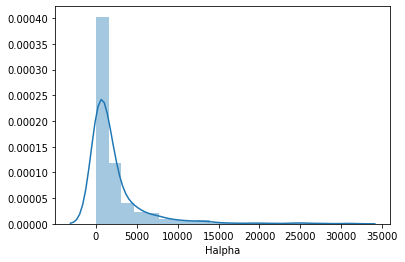

In [8]:
sns.distplot(dataH['Halpha'],bins=20)

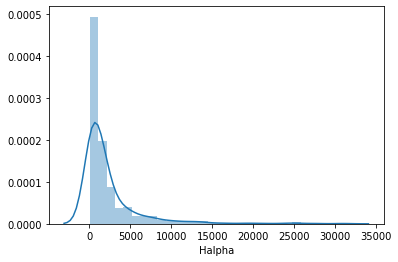

In [9]:
mhf0=(dataH.Halpha<35000)&(dataH.Halpha>5)
sns.distplot(dataH[mhf0]['Halpha'],bins=30)

(61.74143384917406, 148.79556615082592, -0.9978857951459071, 20.59788579514591)

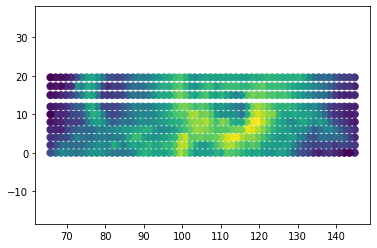

In [10]:
plt.scatter(dataH[mhf0].RA,dataH[mhf0].DE,c=np.log10(dataH.Halpha), s=50)
plt.axis('equal')

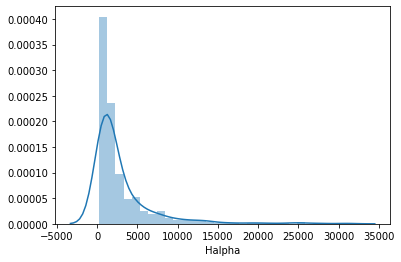

In [11]:
mhf1=(dataH.Halpha<35000)&(dataH.Halpha>200)
sns.distplot(dataH[mhf1]['Halpha'],bins=30)

(63.35063384917405, 144.50436615082594, -0.9978857951459071, 20.59788579514591)

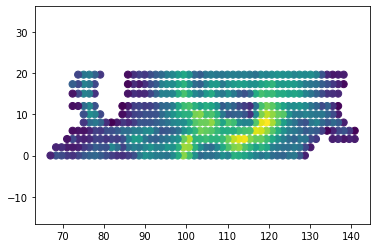

In [12]:
plt.scatter(dataH[mhf1].RA,dataH[mhf1].DE,c=np.log10(dataH[mhf1].Halpha), s=50)
plt.axis('equal')

In [13]:
dataH=dataH[mhf1]

In [14]:
datal=dataH.copy()
datal.Halpha=np.log10(datal.Halpha)
dataH_f=(datal.round(2)).pivot(index='DE', columns='RA', values='Halpha')

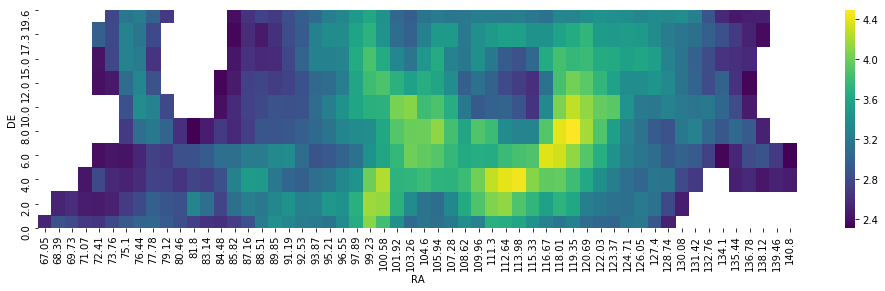

In [15]:
fig, ax = plt.subplots(figsize=(17, 4))
sns.heatmap(dataH_f, cmap="viridis")
plt.gca().invert_yaxis()

The Emission maps reproduce the HII region, data worked in this case. Lets see, how the other maps behave:

Radial velocity map

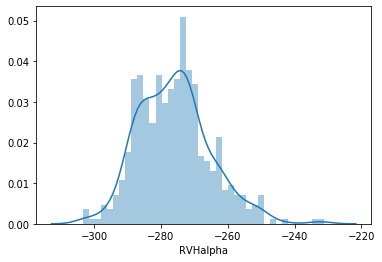

In [16]:
sns.distplot(dataH.RVHalpha,bins=40)

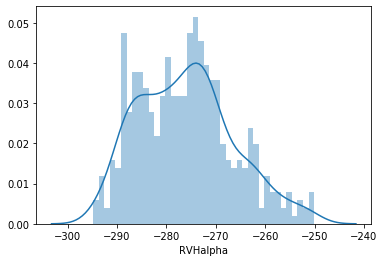

In [17]:
mhrv=(dataH.RVHalpha<-250)&(dataH.RVHalpha>-295)
sns.distplot(dataH[mhrv]['RVHalpha'],bins=40)

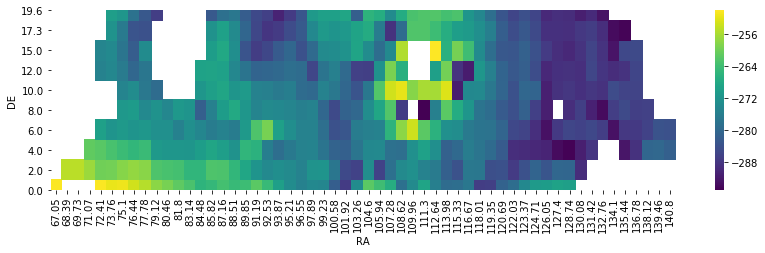

In [18]:
dataH_rv=(dataH[mhrv].round(2)).pivot(index='DE', columns='RA', values='RVHalpha')
fig, ax = plt.subplots(figsize=(14, 3.3))
sns.heatmap(dataH_rv, cmap="viridis")
plt.gca().invert_yaxis()

Data arragement for statistical analysis

In [19]:
a=[dataH.RA,dataH.DE,dataH.RVHalpha]
dataHstat=pd.DataFrame(a).T
dataHstat.columns=['X','Y','RV']
dataHstat.describe()

,X,Y,RV
count,468.000000,468.000000,468.000000
mean,105.214058,9.176282,-276.029803
std,19.052748,6.221415,10.809040
min,67.050000,0.000000,-303.272854
25%,89.847000,4.000000,-284.109884
50%,105.939000,8.000000,-276.184316
75%,120.690000,15.000000,-270.131650
max,140.805000,19.600000,-231.143341


Strcuture Function

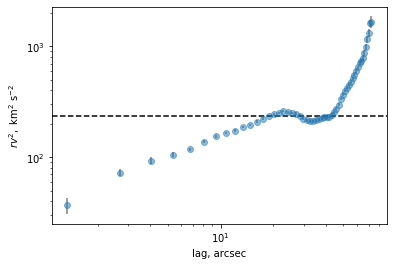

In [20]:
sf_h=sosf(dataHstat)

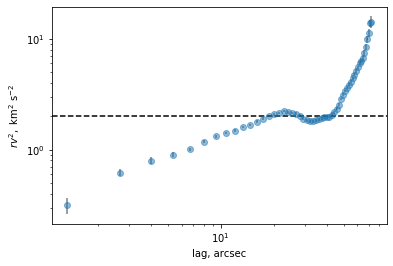

In [21]:
sfn_h=sosfnorm(dataHstat)

Autocorrelation Function

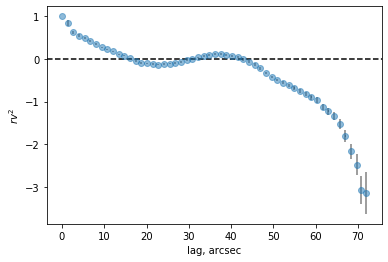

In [22]:
ac_h=acf(dataHstat)

Veocity profiles

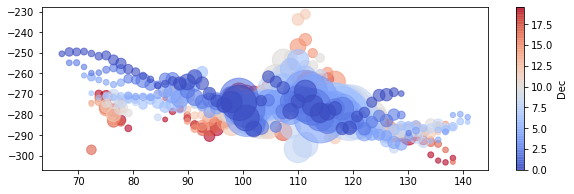

In [23]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(dataH.RA, dataH.RVHalpha, c=dataH.DE, s=dataH.Halpha*0.1, alpha=0.6, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")
#ax.set(xlim=[65.0, 145.0])

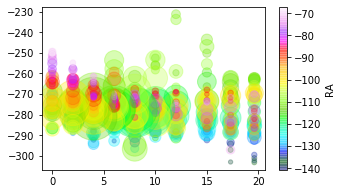

In [24]:
fig, ax = plt.subplots(figsize=(5, 3))
scat = plt.scatter(dataH.DE, dataH.RVHalpha, c=-dataH.RA, s=dataH.Halpha*0.08, alpha=0.3, cmap="gist_ncar")
fig.colorbar(scat, ax=ax).set_label("RA")



Fit a cubic function to V(Ha) vs RA to try and remove the large-scale trend.


In [25]:
pRA = np.poly1d(np.polyfit(dataH.RA, dataH.RVHalpha, 3))
print(pRA)

            3          2
-0.0003667 x + 0.1102 x - 11.06 x + 97.33


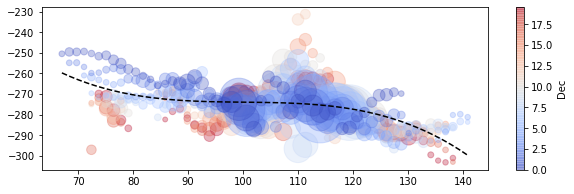

In [26]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(dataH.RA, dataH.RVHalpha, c=dataH.DE, s=dataH.Halpha*0.1, alpha=0.3, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")
RAgrid = np.linspace(dataH.RA.min(), dataH.RA.max())
ax.plot(RAgrid, pRA(RAgrid), c="k", ls="--")

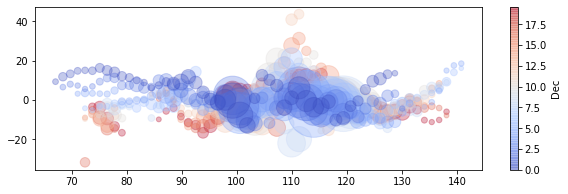

In [27]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(dataH.RA, dataH.RVHalpha - pRA(dataH.RA), c=dataH.DE, s=dataH.Halpha*0.1, alpha=0.3, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")

In [28]:
df1 = pd.DataFrame({'X': dataH.RA, 'Y': dataH.DE, 'RV': dataH.RVHalpha - pRA(dataH.RA)})
df1.describe()

,X,Y,RV
count,468.000000,468.000000,4.680000e+02
mean,105.214058,9.176282,1.799374e-12
std,19.052748,6.221415,8.630999e+00
min,67.050000,0.000000,-3.180087e+01
25%,89.847000,4.000000,-5.437901e+00
50%,105.939000,8.000000,-1.039145e+00
75%,120.690000,15.000000,4.787505e+00
max,140.805000,19.600000,4.366548e+01


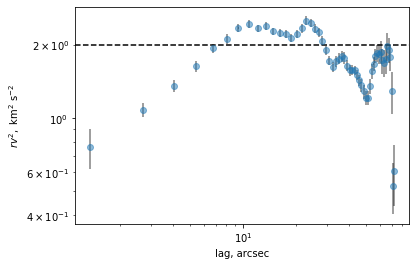

In [29]:
sf_h2=sosfnorm(df1)

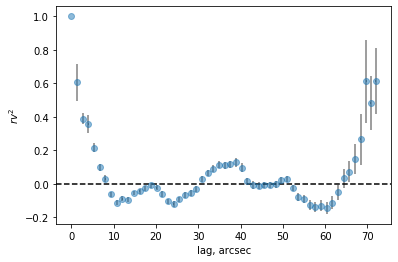

In [30]:
ac_h2=acf(df1)

Since the image has missing data the FFT can not be performed.
To resolve this issue we filter again raw data but just for [SII]

In [31]:
mHH=(data_0.RA<125)&(data_0.RA>85)
dataHH=data_0[mHH]
dataHH.describe()

,RA,DE,Halpha,RVHalpha,SigmHalpha,[NII]6548,RV[NII]6548,Sigm[NII]6548,[NII]6584,RV[NII]6584,Sigm[NII]6584,[SII]6717,RV[SII]6717,Sigm[SII]6717,[SII]6731,RV[SII]6731,Sigm[SII]6731
count,300.00000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,105.26850,9.390000,3998.446333,-274.647015,15.292496,183.149033,-278.081651,15.021794,549.438233,-253.833001,14.873523,377.084900,-231.909824,28.639368,275.529467,-258.121164,28.516452
std,11.62634,6.261276,4669.020580,9.243500,8.539326,176.424696,10.287413,7.898948,529.241090,10.232718,7.885000,287.426399,10.565181,289.840548,216.441297,10.540990,289.198918
min,85.82400,0.000000,226.000000,-296.649181,0.000000,15.370000,-315.358475,0.999554,46.110000,-290.911635,0.000000,54.080000,-271.982230,0.000000,31.460000,-298.099518,0.000000
25%,95.21100,4.000000,1289.750000,-280.900828,9.988411,73.047500,-284.546011,10.253717,219.125000,-260.262993,10.120385,180.150000,-238.436416,5.614076,128.700000,-264.628461,5.510188
50%,105.26850,9.000000,2300.000000,-275.362067,13.445320,131.100000,-279.143528,12.949410,393.250000,-254.889233,12.818243,305.550000,-233.035160,10.228748,215.800000,-259.239242,10.156088
75%,115.32600,15.000000,4924.750000,-269.766206,17.476963,239.825000,-272.550668,17.307156,719.575000,-248.331426,17.168562,485.425000,-226.495624,15.767300,361.250000,-252.714278,15.699860
max,124.71300,19.600000,30960.000000,-231.143341,60.414211,1298.000000,-231.162158,60.686803,3893.000000,-207.162966,60.350881,2137.000000,-193.730983,5029.368305,1568.000000,-220.022653,5018.160282


In [32]:
a=[dataHH.RA,dataHH.DE,dataHH['RVHalpha']]
dataHHstat=pd.DataFrame(a).T
dataHHstat.columns=['X','Y','RV']
dataHHstat.describe()

,X,Y,RV
count,300.00000,300.000000,300.000000
mean,105.26850,9.390000,-274.647015
std,11.62634,6.261276,9.243500
min,85.82400,0.000000,-296.649181
25%,95.21100,4.000000,-280.900828
50%,105.26850,9.000000,-275.362067
75%,115.32600,15.000000,-269.766206
max,124.71300,19.600000,-231.143341


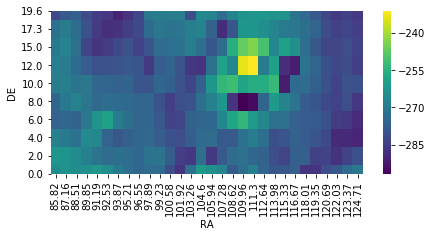

In [33]:
dataHH_rv=(dataHH.round(2)).pivot(index='DE', columns='RA', values='RVHalpha')
fig, ax = plt.subplots(figsize=(7, 3))
sns.heatmap(dataHH_rv, cmap="viridis")
plt.gca().invert_yaxis()

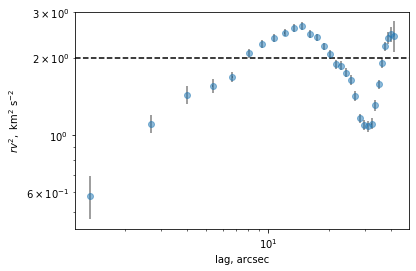

In [34]:
sfn_h3=sosfnorm(dataHHstat)

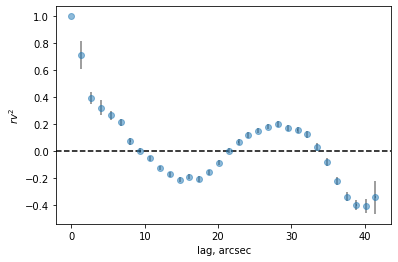

In [35]:
af_h3=acf(dataHHstat)

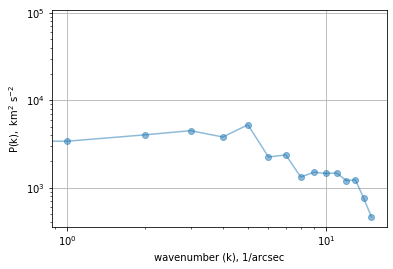

In [36]:
ps_h3=ps(dataHHstat)

In [37]:
#plt.semilogx(sf_3['Lag'],sf_3['Nmqvd'], color='k')
#plt.semilogx(af_3[5],af_3[1], color="gray")
#plt.axhline(y=0, color='k', linestyle='-')
#plt.axhline(y=2, color='k', linestyle='dotted')
#plt.title('Statistical Functions')
#plt.ylabel('R(l),S(l)')
#plt.xlabel('log l (pc)')
#plt.text(10,-1, nom_c, fontsize=20)#name
#plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)

[Text(0, 0.5, 'R(l),S(l)'), Text(0.5, 0, 'lag, arcsec')]

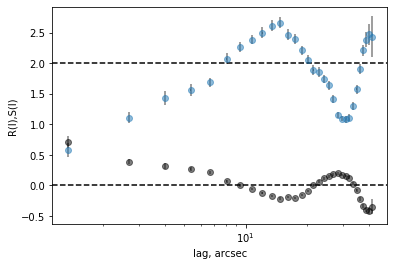

In [38]:
fig, ax=plt.subplots()
ax.errorbar(sfn_h3['Lag'],sfn_h3['Nmqvd'],xerr=sfn_h3.ErrX,yerr=sfn_h3.ErrY, fmt="o", ecolor='k', alpha=0.5)
ax.set(xscale='log')
ax.axhline(y=2, color='k', linestyle='--')
ax.errorbar(af_h3['Lag pc'],af_h3['Nmqvd'],xerr=af_h3.ErrX,yerr=af_h3.ErrY, fmt="o", color='k', ecolor='k', alpha=0.5)
ax.axhline(y=0, color='k', linestyle='--')
ax.set(xlabel='lag, arcsec', ylabel='R(l),S(l)')
#sgrid = np.logspace(.08, 1.35)
#ax.plot(sgrid, 38.0*sgrid**(2/3), color="k", lw=0.8)

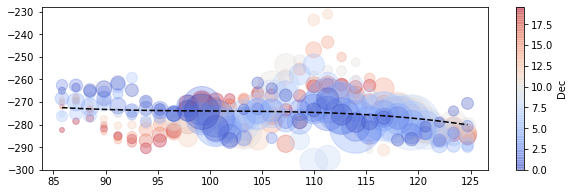

In [39]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(dataHH.RA, dataHH.RVHalpha, c=dataHH.DE, s=dataHH.Halpha*0.1, alpha=0.3, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")
RAgrid = np.linspace(dataHH.RA.min(), dataHH.RA.max())
ax.plot(RAgrid, pRA(RAgrid), c="k", ls="--")

Sigma map

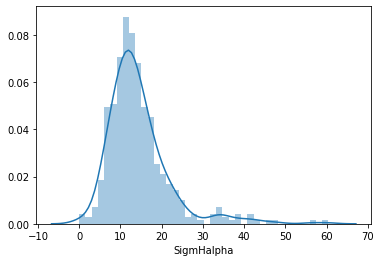

In [40]:
sns.distplot(dataH.SigmHalpha,bins=40)

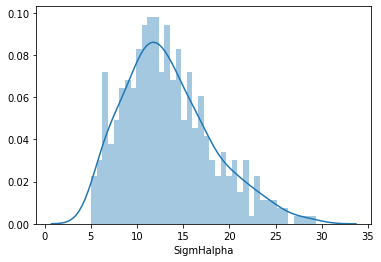

In [41]:
mhs=(dataH.SigmHalpha<30)&(dataH.SigmHalpha>5)
sns.distplot(dataH[mhs]['SigmHalpha'],bins=40)

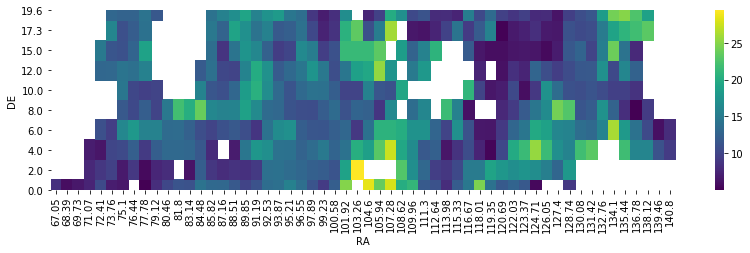

In [42]:
dataH_s=(dataH[mhs].round(2)).pivot(index='DE', columns='RA', values='SigmHalpha')
fig, ax = plt.subplots(figsize=(14, 3.3))
sns.heatmap(dataH_s, cmap="viridis")
plt.gca().invert_yaxis()

I vs Sigma diagnostic diagram

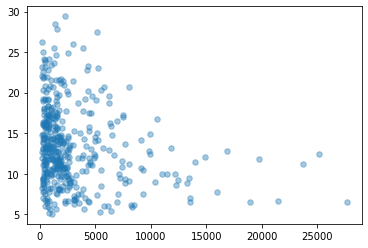

In [43]:
plt.scatter(dataH[mhs].Halpha,dataH[mhs].SigmHalpha, alpha=0.4, s=30)

[NII] 6585 emission line

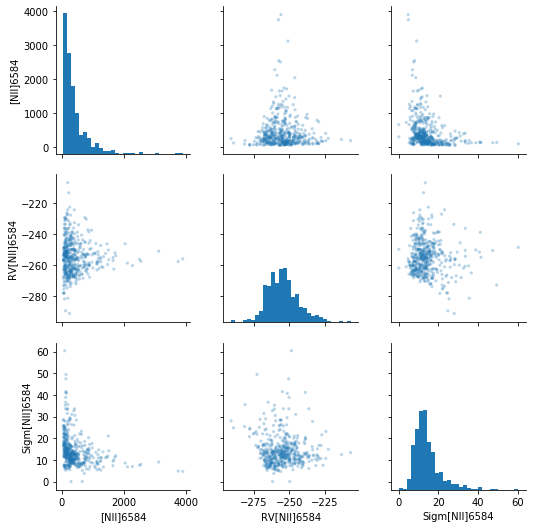

In [44]:
dataN_0=dataH.copy()
dataN=dataH.copy()
sns.pairplot(dataN_0,
             vars=["[NII]6584", "RV[NII]6584", "Sigm[NII]6584"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

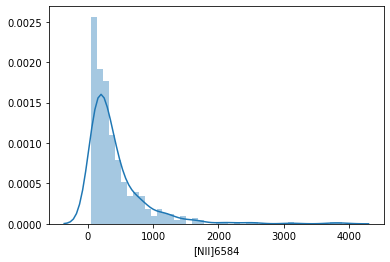

In [45]:
sns.distplot(dataN['[NII]6584'])

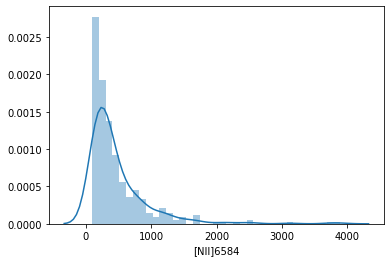

In [46]:
mnf=(dataN['[NII]6584']<4000)&(dataN['[NII]6584']>100)
sns.distplot(dataN[mnf]['[NII]6584'])

In [47]:
dataN=dataN[mnf]

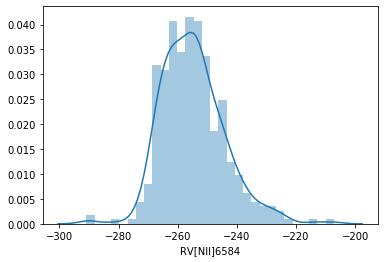

In [48]:
sns.distplot(dataN['RV[NII]6584'], bins=30)

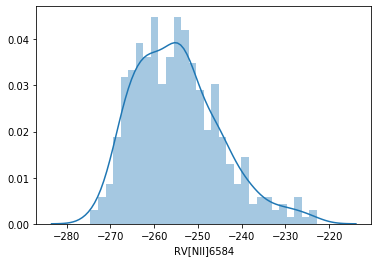

In [49]:
mnrv=(dataN['RV[NII]6584']>-280)&(dataN['RV[NII]6584']<-220)
sns.distplot(dataN[mnrv]['RV[NII]6584'], bins=30)

In [50]:
dataN=dataN[mnrv]

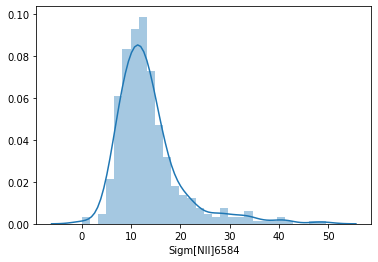

In [51]:
sns.distplot(dataN['Sigm[NII]6584'])

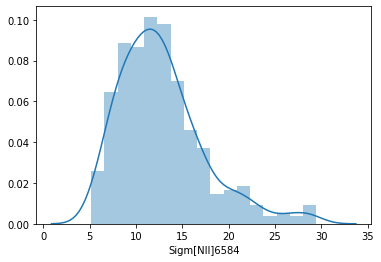

In [52]:
mns=(dataN['Sigm[NII]6584']>5)&(dataN['Sigm[NII]6584']<30)
sns.distplot(dataN[mns]['Sigm[NII]6584'])

In [53]:
dataN=dataN[mns]

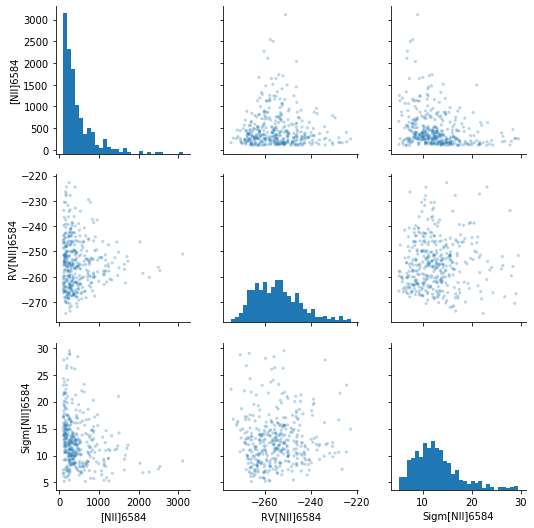

In [54]:
sns.pairplot(dataN,
             vars=["[NII]6584", "RV[NII]6584", "Sigm[NII]6584"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

In [55]:
dataNl=dataN.copy()
dataNl.Halpha=np.log10(data['[NII]6584'])
dataN_f=(dataN.round(2)).pivot(index='DE', columns='RA', values='[NII]6584')
dataN_rv=(dataN.round(2)).pivot(index='DE', columns='RA', values='RV[NII]6584')
dataN_s=(dataN.round(2)).pivot(index='DE', columns='RA', values='Sigm[NII]6584')

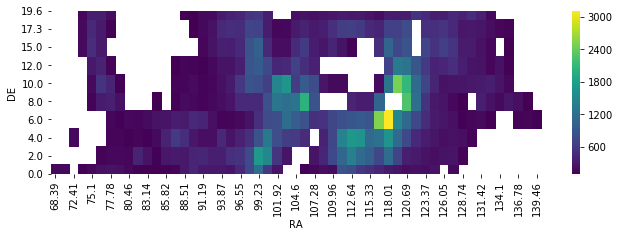

In [56]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataN_f, cmap="viridis")
plt.gca().invert_yaxis()

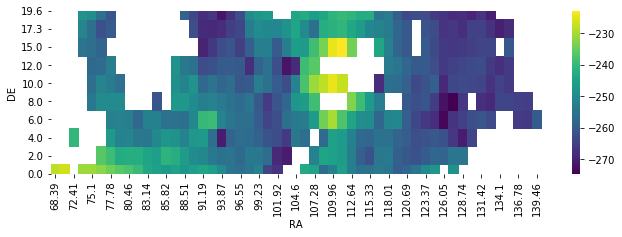

In [57]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataN_rv, cmap="viridis")
plt.gca().invert_yaxis()


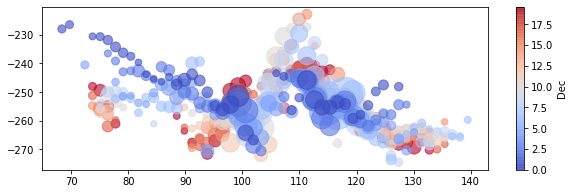

In [58]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(dataN.RA, dataN['RV[NII]6584'], c=dataN.DE, s=dataN['[NII]6584']*0.4, alpha=0.6, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")

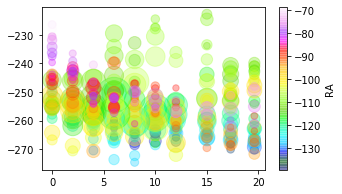

In [59]:
fig, ax = plt.subplots(figsize=(5, 3))
scat = plt.scatter(dataN.DE, dataN['RV[NII]6584'], c=-dataN.RA, s=dataN['[NII]6584']*0.4, alpha=0.3, cmap="gist_ncar")
fig.colorbar(scat, ax=ax).set_label("RA")

In [60]:
a=[dataN.RA,dataN.DE,dataN['RV[NII]6584']]
dataNstat=pd.DataFrame(a).T
dataNstat.columns=['X','Y','RV']
dataNstat.describe()

,X,Y,RV
count,379.000000,379.000000,379.000000
mean,105.769164,9.087071,-254.720650
std,17.526613,6.242012,9.887710
min,68.391000,0.000000,-274.562657
25%,92.529000,4.000000,-262.312308
50%,105.939000,8.000000,-255.390177
75%,120.690000,15.000000,-249.037301
max,139.464000,19.600000,-222.783300


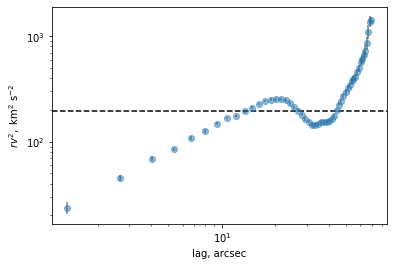

In [61]:
sf_n=sosf(dataNstat)

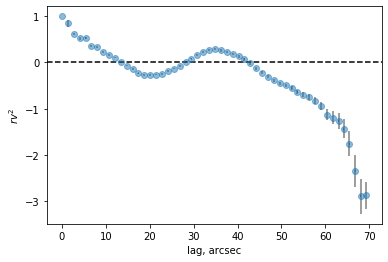

In [62]:
af_n=acf(dataNstat)

Since the image has missing data the FFT can not be performed.
To resolve this issue we filter again raw data but just for [NII]

In [63]:
mNN=(data_0.RA<125)&(data_0.RA>90)
dataNN=data_0[mNN]
dataNN.describe()

,RA,DE,Halpha,RVHalpha,SigmHalpha,[NII]6548,RV[NII]6548,Sigm[NII]6548,[NII]6584,RV[NII]6584,Sigm[NII]6584,[SII]6717,RV[SII]6717,Sigm[SII]6717,[SII]6731,RV[SII]6731,Sigm[SII]6731
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,107.950500,9.390000,4462.242308,-275.149302,15.663124,201.258077,-278.401656,14.938647,603.764000,-254.151305,14.788877,408.148654,-232.172951,31.242521,299.310692,-258.383236,31.112336
std,10.076897,6.262888,4842.478368,9.606268,9.003773,182.028182,10.797795,8.327424,546.048701,10.740386,8.312576,293.809144,11.091419,311.331492,221.288690,11.066194,310.642340
min,91.188000,0.000000,401.400000,-296.649181,0.000000,27.770000,-315.358475,0.999554,83.300000,-290.911635,0.000000,65.180000,-271.982230,0.000000,43.930000,-298.099518,0.000000
25%,99.234000,4.000000,1514.000000,-281.448994,10.042098,85.150000,-284.843605,9.846227,255.450000,-260.559005,9.711760,202.850000,-239.050195,5.292281,147.350000,-265.240872,5.183417
50%,107.950500,9.000000,2611.500000,-275.933074,13.534091,143.800000,-279.509798,12.625755,431.500000,-255.253556,12.494704,335.650000,-234.218080,9.990155,240.150000,-260.419525,9.916830
75%,116.667000,15.000000,5471.000000,-271.285083,17.851654,255.125000,-273.706708,16.791739,765.475000,-249.481319,16.654450,517.400000,-226.227793,15.944005,388.025000,-252.447044,15.876529
max,124.713000,19.600000,30960.000000,-231.143341,60.414211,1298.000000,-231.162158,60.686803,3893.000000,-207.162966,60.350881,2137.000000,-193.730983,5029.368305,1568.000000,-220.022653,5018.160282


In [64]:
a=[dataNN.RA,dataNN.DE,dataNN['RV[NII]6584']]
dataNNstat=pd.DataFrame(a).T
dataNNstat.columns=['X','Y','RV']
dataNNstat.describe()

,X,Y,RV
count,260.000000,260.000000,260.000000
mean,107.950500,9.390000,-254.151305
std,10.076897,6.262888,10.740386
min,91.188000,0.000000,-290.911635
25%,99.234000,4.000000,-260.559005
50%,107.950500,9.000000,-255.253556
75%,116.667000,15.000000,-249.481319
max,124.713000,19.600000,-207.162966


(0.0, 26.0, 0.0, 10.0)

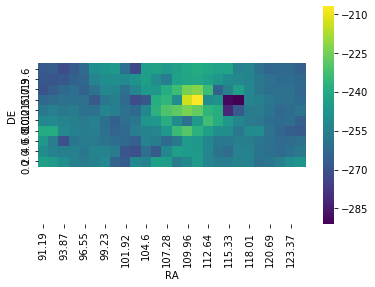

In [65]:
dataNN_rv=(dataNN.round(2)).pivot(index='DE', columns='RA', values='RV[NII]6584')
sns.heatmap(dataNN_rv, cmap="viridis")
plt.gca().invert_yaxis()
plt.axis('equal')

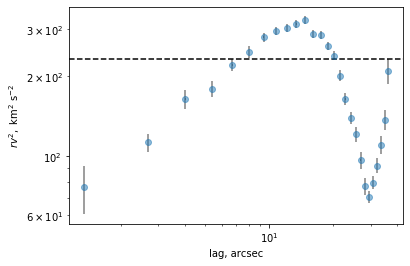

In [66]:
sf_n2=sosf(dataNNstat)

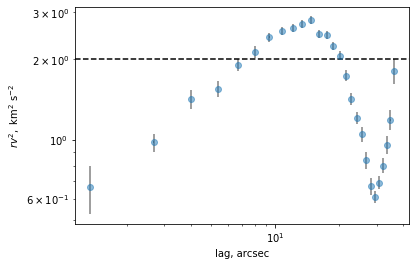

In [67]:
sfn_n2=sosfnorm(dataNNstat)

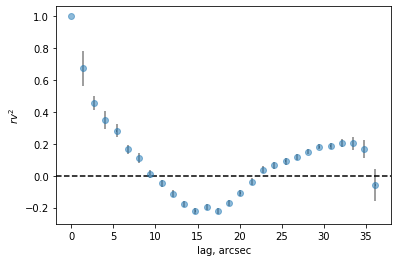

In [68]:
af_n2=acf(dataNNstat)

[Text(0, 0.5, 'R(l),S(l)'), Text(0.5, 0, 'lag, arcsec')]

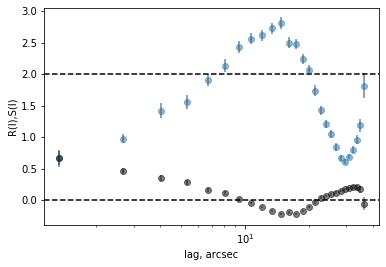

In [69]:
fig, ax=plt.subplots()
ax.errorbar(sfn_n2['Lag'],sfn_n2['Nmqvd'],xerr=sfn_n2.ErrX,yerr=sfn_n2.ErrY, fmt="o", ecolor='k', alpha=0.5)
ax.set(xscale='log')
ax.axhline(y=2, color='k', linestyle='--')
ax.errorbar(af_n2['Lag pc'],af_n2['Nmqvd'],xerr=af_n2.ErrX,yerr=af_n2.ErrY, fmt="o", color='k', ecolor='k', alpha=0.5)
ax.axhline(y=0, color='k', linestyle='--')
ax.set(xlabel='lag, arcsec', ylabel='R(l),S(l)')

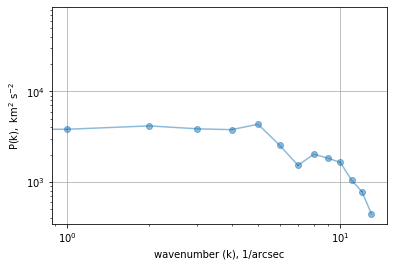

In [70]:
ps_n2=ps(dataNNstat)

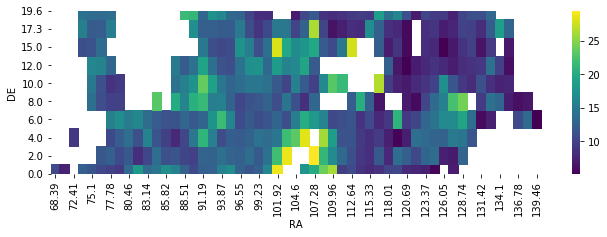

In [71]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataN_s, cmap="viridis")
plt.gca().invert_yaxis()

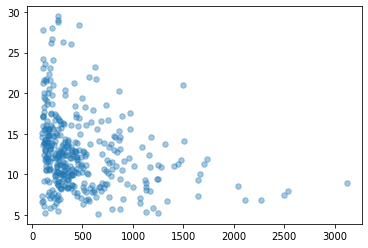

In [72]:
plt.scatter(dataN['[NII]6584'],dataN['Sigm[NII]6584'], alpha=0.4, s=30)

[SII] 6731 emission line

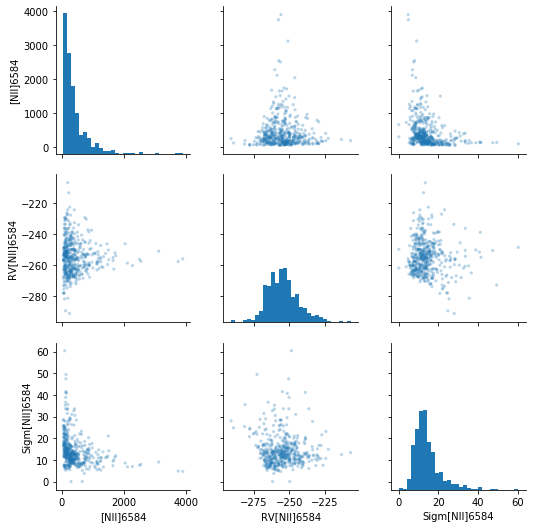

In [73]:
dataS_0=dataH.copy()
dataS=dataH.copy()
sns.pairplot(dataS_0,
             vars=["[NII]6584", "RV[NII]6584", "Sigm[NII]6584"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

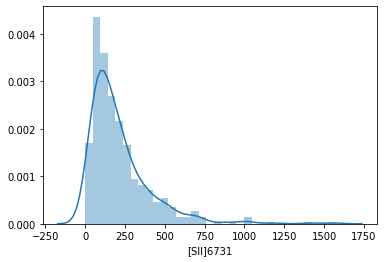

In [74]:
sns.distplot(dataS_0['[SII]6731'])

/home/zalenovo/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


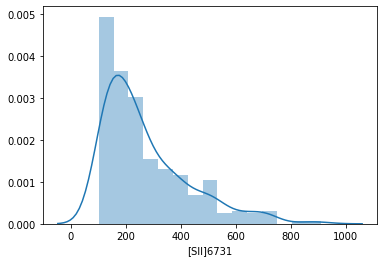

In [75]:
msf=(dataS['[SII]6731']<1000)&(dataN['[SII]6731']>100)
sns.distplot(dataN[msf]['[SII]6731'])

In [76]:
dataS=dataS[msf]

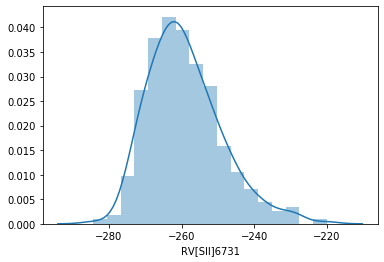

In [77]:
sns.distplot(dataS['RV[SII]6731'])

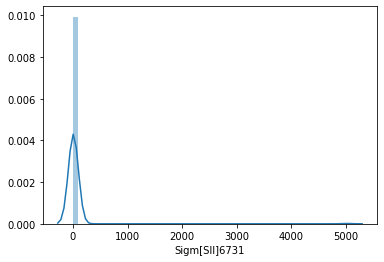

In [78]:
sns.distplot(dataS['Sigm[SII]6731'])

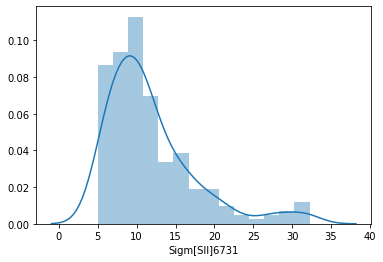

In [79]:
mss=(dataS['Sigm[SII]6731']>5)&(dataS['Sigm[SII]6731']<50)
sns.distplot(dataS[mss]['Sigm[SII]6731'])

In [80]:
dataS=dataS[mss]

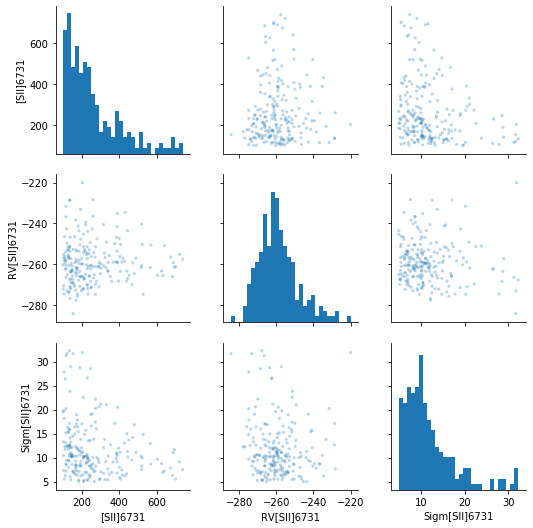

In [81]:
sns.pairplot(dataS,
             vars=["[SII]6731", "RV[SII]6731", "Sigm[SII]6731"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

In [82]:
dataSl=data.copy()
dataSl.Halpha=np.log10(data['[SII]6731'])
dataS_f=(dataS.round(2)).pivot(index='DE', columns='RA', values='[SII]6731')
dataS_rv=(dataS.round(2)).pivot(index='DE', columns='RA', values='RV[SII]6731')
dataS_s=(dataS.round(2)).pivot(index='DE', columns='RA', values='Sigm[SII]6731')

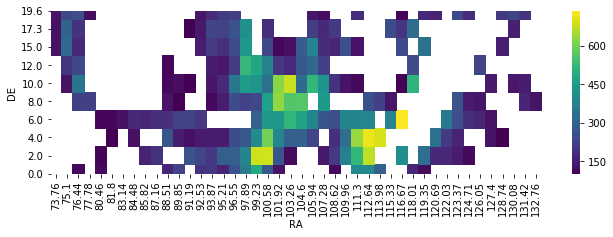

In [83]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataS_f, cmap="viridis")
plt.gca().invert_yaxis()

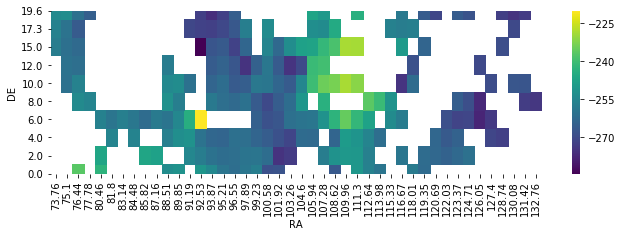

In [84]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataS_rv, cmap="viridis")
plt.gca().invert_yaxis()

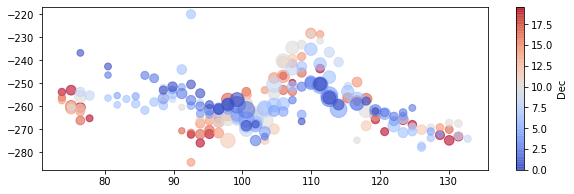

In [85]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(dataS.RA, dataS['RV[SII]6731'], c=dataS.DE, s=dataS['[SII]6731']*0.4, alpha=0.6, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")

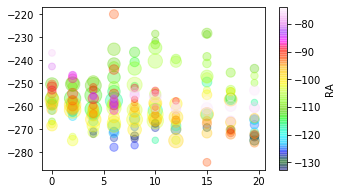

In [86]:
fig, ax = plt.subplots(figsize=(5, 3))
scat = plt.scatter(dataS.DE, dataS['RV[SII]6731'], c=-dataS.RA, s=dataS['[SII]6731']*0.4, alpha=0.3, cmap="gist_ncar")
fig.colorbar(scat, ax=ax).set_label("RA")

In [87]:
a=[dataS.RA,dataS.DE,dataS['RV[SII]6731']]
dataSstat=pd.DataFrame(a).T
dataSstat.columns=['X','Y','RV']
dataSstat.describe()

,X,Y,RV
count,214.000000,214.000000,214.000000
mean,102.761958,8.852804,-259.000521
std,14.581423,6.030958,10.522173
min,73.755000,0.000000,-284.292429
25%,93.870000,4.000000,-266.120517
50%,101.916000,8.000000,-260.419525
75%,112.644000,15.000000,-253.671867
max,132.759000,19.600000,-220.022653


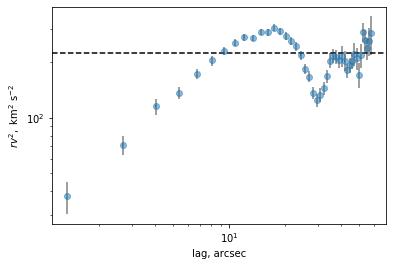

In [88]:
sf_s=sosf(dataSstat)

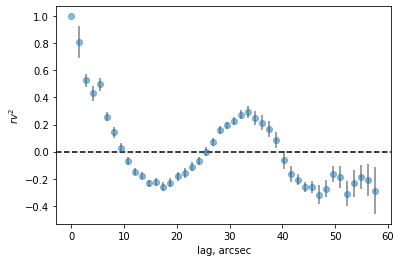

In [89]:
af_s=acf(dataSstat)

Since the image has missing data the FFT can not be performed.
To resolve this issue we filter again raw data but just for [SII]

In [90]:
ms=(data_0.RA<125)&(data_0.RA>90)
dataS2=data_0[ms]
dataS2.describe()

,RA,DE,Halpha,RVHalpha,SigmHalpha,[NII]6548,RV[NII]6548,Sigm[NII]6548,[NII]6584,RV[NII]6584,Sigm[NII]6584,[SII]6717,RV[SII]6717,Sigm[SII]6717,[SII]6731,RV[SII]6731,Sigm[SII]6731
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,107.950500,9.390000,4462.242308,-275.149302,15.663124,201.258077,-278.401656,14.938647,603.764000,-254.151305,14.788877,408.148654,-232.172951,31.242521,299.310692,-258.383236,31.112336
std,10.076897,6.262888,4842.478368,9.606268,9.003773,182.028182,10.797795,8.327424,546.048701,10.740386,8.312576,293.809144,11.091419,311.331492,221.288690,11.066194,310.642340
min,91.188000,0.000000,401.400000,-296.649181,0.000000,27.770000,-315.358475,0.999554,83.300000,-290.911635,0.000000,65.180000,-271.982230,0.000000,43.930000,-298.099518,0.000000
25%,99.234000,4.000000,1514.000000,-281.448994,10.042098,85.150000,-284.843605,9.846227,255.450000,-260.559005,9.711760,202.850000,-239.050195,5.292281,147.350000,-265.240872,5.183417
50%,107.950500,9.000000,2611.500000,-275.933074,13.534091,143.800000,-279.509798,12.625755,431.500000,-255.253556,12.494704,335.650000,-234.218080,9.990155,240.150000,-260.419525,9.916830
75%,116.667000,15.000000,5471.000000,-271.285083,17.851654,255.125000,-273.706708,16.791739,765.475000,-249.481319,16.654450,517.400000,-226.227793,15.944005,388.025000,-252.447044,15.876529
max,124.713000,19.600000,30960.000000,-231.143341,60.414211,1298.000000,-231.162158,60.686803,3893.000000,-207.162966,60.350881,2137.000000,-193.730983,5029.368305,1568.000000,-220.022653,5018.160282


In [91]:
a=[dataS2.RA,dataS2.DE,dataS2['RV[SII]6731']]
dataS2stat=pd.DataFrame(a).T
dataS2stat.columns=['X','Y','RV']
dataS2stat.describe()

,X,Y,RV
count,260.000000,260.000000,260.000000
mean,107.950500,9.390000,-258.383236
std,10.076897,6.262888,11.066194
min,91.188000,0.000000,-298.099518
25%,99.234000,4.000000,-265.240872
50%,107.950500,9.000000,-260.419525
75%,116.667000,15.000000,-252.447044
max,124.713000,19.600000,-220.022653


(0.0, 26.0, 0.0, 10.0)

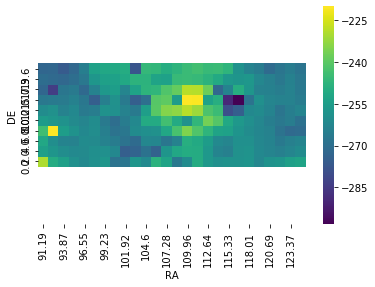

In [92]:
dataS2_rv=(dataS2.round(2)).pivot(index='DE', columns='RA', values='RV[SII]6731')
#fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataS2_rv, cmap="viridis")
plt.gca().invert_yaxis()
plt.axis('equal')

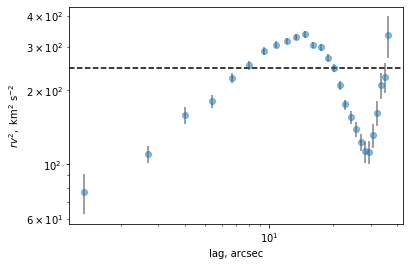

In [93]:
sf_s2=sosf(dataS2stat)

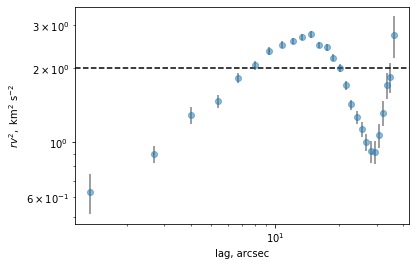

In [94]:
sfn_s2=sosfnorm(dataS2stat)

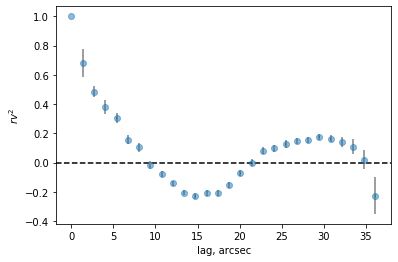

In [95]:
af_s2=acf(dataS2stat)

[Text(0, 0.5, 'R(l),S(l)'), Text(0.5, 0, 'lag, arcsec')]

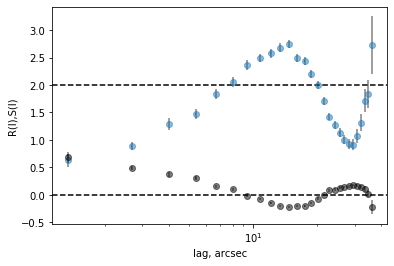

In [96]:
fig, ax=plt.subplots()
ax.errorbar(sfn_s2['Lag'],sfn_s2['Nmqvd'],xerr=sfn_s2.ErrX,yerr=sfn_s2.ErrY, fmt="o", ecolor='k', alpha=0.5)
ax.set(xscale='log')
ax.axhline(y=2, color='k', linestyle='--')
ax.errorbar(af_s2['Lag pc'],af_s2['Nmqvd'],xerr=af_s2.ErrX,yerr=af_s2.ErrY, fmt="o", color='k', ecolor='k', alpha=0.5)
ax.axhline(y=0, color='k', linestyle='--')
ax.set(xlabel='lag, arcsec', ylabel='R(l),S(l)')


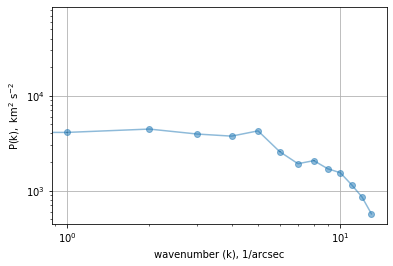

In [97]:
ps_s2=ps(dataS2stat)

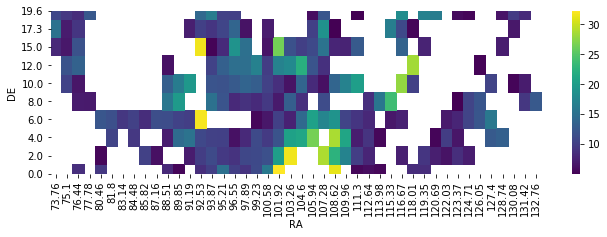

In [98]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataS_s, cmap="viridis")
plt.gca().invert_yaxis()

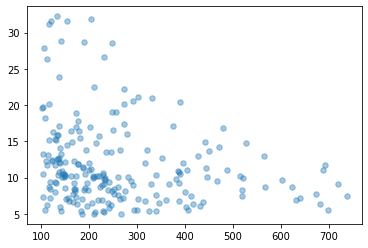

In [99]:
plt.scatter(dataS['[SII]6731'],dataS['Sigm[SII]6731'], alpha=0.4, s=30)

Electron density

In [100]:
def eden(R):
    """Approximate sii electron density from R=6717/6731"""
    RR = 1.0/R
    return 2489*(RR - 0.6971) / (2.3380 - RR)

In [101]:
fSii1=dataS['[SII]6717']
vSii1=dataS['RV[SII]6717']
sSii1=dataS['Sigm[SII]6717']

fSii2=dataS['[SII]6731']
vSii2=dataS['RV[SII]6731']
sSii2=dataS['Sigm[SII]6731']

In [102]:
dfSii = pd.DataFrame(
    {'log_F': np.log10(fSii1 + fSii2), 
     'R12': fSii1/fSii2,
     'dV12': vSii1 - vSii2, 
     'V': (fSii1*vSii1 + fSii2*vSii2)/(fSii1 + fSii2),
     'sigma': np.sqrt((fSii1*sSii1**2 + fSii2*sSii2**2)/(fSii1 + fSii2)),
     'sigma12': sSii1/sSii2,
     'RA': dataS.RA,
     'DE': dataS.DE,
     'Ed':eden(fSii1/fSii2),
    }
)

In [103]:
dfSii.describe()

,log_F,R12,dV12,V,sigma,sigma12,RA,DE,Ed
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,2.734343,1.390634,26.209204,-243.778832,11.839727,1.008349,102.761958,8.852804,58.768873
std,0.216631,0.103581,0.027256,10.492843,5.814361,0.004665,14.581423,6.030958,311.037911
min,2.379849,0.573674,26.148126,-272.328993,5.071862,1.002723,73.755000,0.000000,-173.125668
25%,2.547620,1.343600,26.189831,-250.777784,7.829206,1.004908,93.870000,4.000000,-9.309063
50%,2.714497,1.389986,26.204231,-244.957289,10.300737,1.007058,101.916000,8.000000,34.341603
75%,2.884185,1.447304,26.223554,-238.497018,13.821533,1.010602,112.644000,15.000000,73.666435
max,3.241297,1.740848,26.299503,-210.438174,32.293952,1.022329,132.759000,19.600000,4376.940662


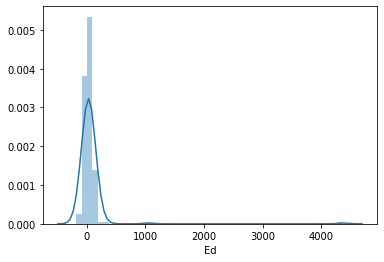

In [104]:
sns.distplot(dfSii['Ed'])

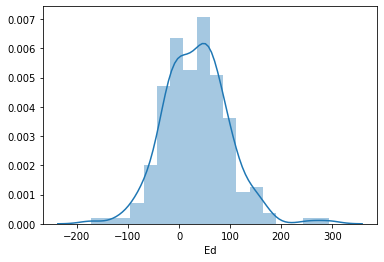

In [105]:
msd=(dfSii['Ed']<1000)
sns.distplot(dfSii[msd]['Ed'])

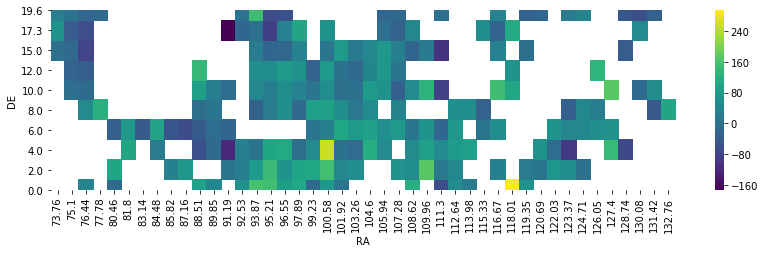

In [106]:
dataS_d=(dfSii[msd].round(2)).pivot(index='DE', columns='RA', values='Ed')
fig, ax = plt.subplots(figsize=(14, 3.3))
sns.heatmap(dataS_d, cmap="viridis")
plt.gca().invert_yaxis()


In [107]:
input_file='datosNGC604a.txt'

data_0B=pd.read_table(input_file)
data=data_0B.copy()
data_2B=(data.round(2)).pivot(index='DE', columns='RA', values='[OIII]5007')

In [108]:
data.describe()

,RA,DE,Hbeta,RVHbeta,SigmHbeta,[OIII]4959,RV[OIII]4959,Sigm[OIII]4959,[OIII]5007,RV[OIII]5007,Sigm[OIII]5007
count,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000,1.333000e+03,1333.000000,1333.000000,1.333000e+03,1333.000000,1333.000000
mean,108.007532,9.351613,37.157464,-309.293008,230.467592,-7.379595e+16,249.178597,550.280848,-2.213803e+17,224.584914,544.304119
std,61.956092,6.596011,273.525984,781.898267,1558.331837,2.694310e+18,5654.075888,3148.490294,8.082657e+18,5598.754562,3117.782689
min,1.430000,0.000000,-1915.000000,-19921.950000,0.000000,-9.837000e+19,-4875.320000,0.000000,-2.951000e+20,-4849.770000,0.000000
25%,54.360000,4.000000,-4.700000,-315.890000,3.880000,-1.890000e+00,-324.580000,9.580000,-5.670000e+00,-343.550000,6.900000
50%,108.710000,8.000000,5.490000,-239.910000,23.100000,8.900000e-01,-292.420000,27.080000,2.660000e+00,-311.700000,25.990000
75%,161.640000,15.000000,23.690000,-207.780000,61.560000,7.440000e+00,-189.710000,71.020000,2.232000e+01,-210.000000,70.020000
max,214.560000,19.600000,6126.000000,2234.470000,31720.860000,5.941000e+09,129082.250000,48095.580000,1.782000e+10,127797.120000,47625.000000


/home/zalenovo/my_project_dir/my_project_env/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-9.231694900576741, 225.22169490057675, -0.987998770755577, 20.58799877075558)

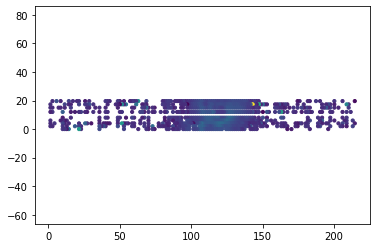

In [109]:
plt.scatter(data.RA,data.DE,c=np.log10(data['[OIII]5007']), s=10)
plt.axis('equal')

In [110]:
m=(data.RA<145)&(data.RA>100)
dataB=data[m]
dataB.describe()

,RA,DE,Hbeta,RVHbeta,SigmHbeta,[OIII]4959,RV[OIII]4959,Sigm[OIII]4959,[OIII]5007,RV[OIII]5007,Sigm[OIII]5007
count,288.000000,288.000000,288.000000,288.000000,288.000000,2.880000e+02,288.000000,288.000000,2.880000e+02,288.000000,288.000000
mean,122.299375,9.322222,97.501076,-248.563125,132.133299,2.062853e+07,-304.059653,180.412535,6.187517e+07,-323.238437,177.643611
std,13.230577,6.596931,122.441404,230.524279,829.739197,3.500768e+08,197.955299,1590.080810,1.050054e+09,196.019375,1574.624044
min,100.130000,0.000000,0.000000,-3778.580000,0.000000,-4.000000e+00,-2670.800000,0.000000,-1.199000e+01,-2666.820000,0.000000
25%,111.212500,4.000000,28.942500,-243.945000,15.420000,1.169500e+01,-309.357500,16.270000,3.509250e+01,-328.485000,14.740000
50%,122.295000,8.000000,54.405000,-235.035000,19.550000,2.496000e+01,-302.060000,20.795000,7.487500e+01,-321.250000,19.545000
75%,133.387500,15.000000,121.200000,-227.107500,26.387500,5.966500e+01,-294.470000,27.397500,1.790250e+02,-313.740000,26.320000
max,144.470000,19.600000,823.900000,931.940000,9053.850000,5.941000e+09,2004.110000,19852.040000,1.782000e+10,1962.360000,19657.800000


[OIII] emission line analysis

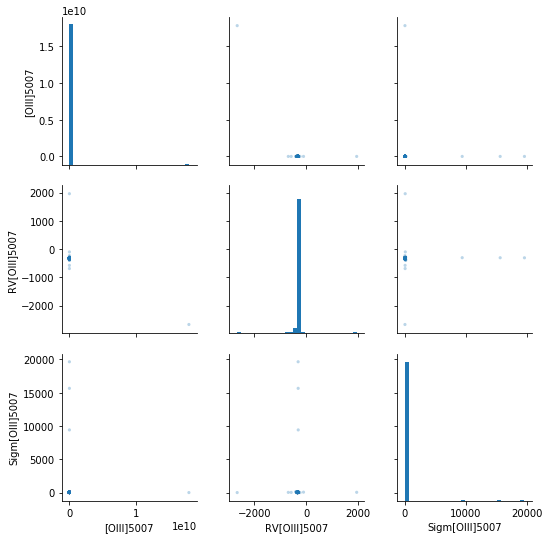

In [111]:
sns.pairplot(dataB,
             vars=["[OIII]5007", "RV[OIII]5007", "Sigm[OIII]5007"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

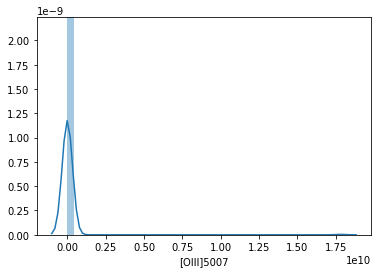

In [112]:
sns.distplot(dataB['[OIII]5007'], bins=40)

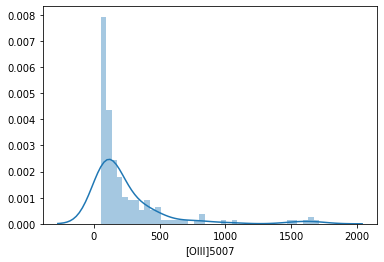

In [113]:
mhb=(dataB['[OIII]5007']<10000)&(dataB['[OIII]5007']>50)
sns.distplot(dataB[mhb]['[OIII]5007'],bins=40)

(99.47225558498825,
 145.12774441501173,
 -1.0011627582134726,
 20.601162758213476)

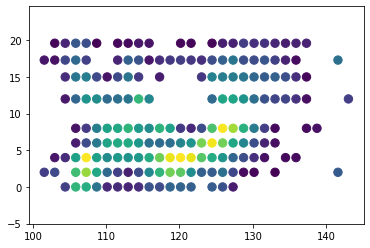

In [114]:
plt.scatter(dataB[mhb].RA,dataB[mhb].DE,c=np.log10(dataB[mhb]['[OIII]5007']), s=70)
plt.axis('equal')

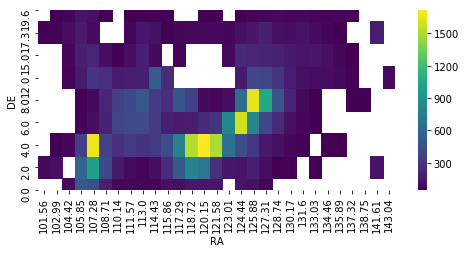

In [115]:
dataB=dataB[mhb]
dataB_f=(dataB.round(2)).pivot(index='DE', columns='RA', values='[OIII]5007')
fig, ax = plt.subplots(figsize=(8, 3.3))
sns.heatmap(dataB_f, cmap="viridis")
plt.gca().invert_yaxis()

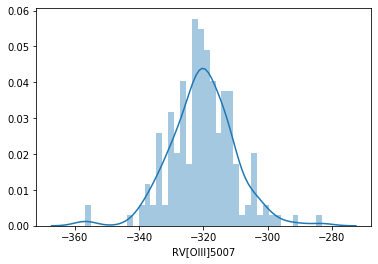

In [116]:
sns.distplot(dataB['RV[OIII]5007'], bins=40)

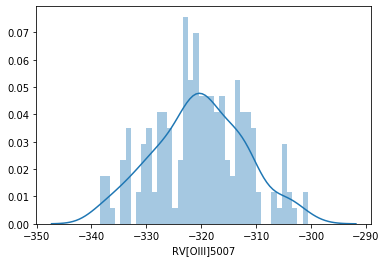

In [117]:
mbrv=(dataB['RV[OIII]5007']>-340)&(dataB['RV[OIII]5007']<-300)
sns.distplot(dataB[mbrv]['RV[OIII]5007'], bins=40)

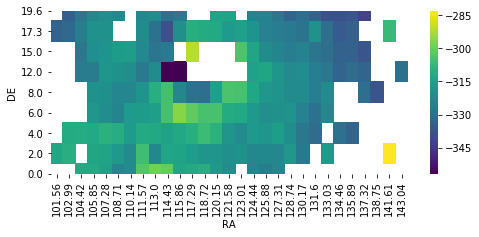

In [118]:
dataB_rv=(dataB.round(2)).pivot(index='DE', columns='RA', values='RV[OIII]5007')
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(dataB_rv, cmap="viridis")
plt.gca().invert_yaxis()

In [119]:
a=[dataB[mbrv].RA,dataB[mbrv].DE,dataB[mbrv]['RV[OIII]5007']]
dataOstat=pd.DataFrame(a).T
dataOstat.columns=['X','Y','RV']
dataOstat.describe()

,X,Y,RV
count,181.000000,181.000000,181.000000
mean,119.750608,9.570166,-320.363481
std,10.232093,6.540353,8.277964
min,101.560000,0.000000,-338.520000
25%,111.570000,4.000000,-326.370000
50%,120.150000,8.000000,-320.560000
75%,128.740000,15.000000,-314.400000
max,143.040000,19.600000,-300.570000


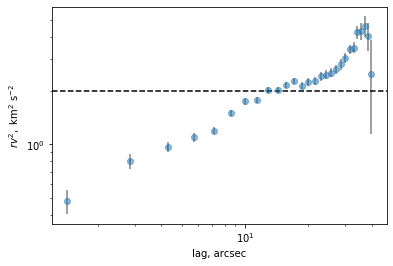

In [120]:
sf_o=sosfnorm(dataOstat)

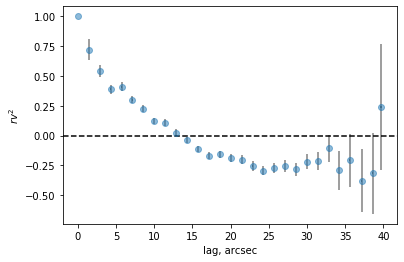

In [121]:
af_o=acf(dataOstat)

In [122]:
mOO=(data_0B.RA<137)&(data_0B.RA>100)
dataOO=data_0B[mOO]
dataOO.describe()

,RA,DE,Hbeta,RVHbeta,SigmHbeta,[OIII]4959,RV[OIII]4959,Sigm[OIII]4959,[OIII]5007,RV[OIII]5007,Sigm[OIII]5007
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000
mean,118.008077,9.322222,112.384658,-247.782521,115.841197,67.237821,-300.475427,215.663761,201.713718,-319.689103,212.543077
std,10.751691,6.599585,121.920563,232.107438,809.870271,97.284595,10.138844,1762.794336,291.855599,10.042024,1745.658496
min,100.130000,0.000000,0.000000,-3778.580000,0.000000,-1.350000,-337.880000,0.000000,-4.040000,-356.720000,0.000000
25%,108.710000,4.000000,39.770000,-239.597500,15.710000,17.687500,-306.605000,16.620000,53.052500,-325.755000,15.100000
50%,118.005000,8.000000,69.040000,-232.970000,19.190000,32.835000,-300.790000,21.000000,98.505000,-320.000000,19.760000
75%,127.310000,15.000000,141.000000,-226.475000,25.607500,72.400000,-294.215000,27.140000,217.175000,-313.485000,26.060000
max,135.890000,19.600000,823.900000,-163.560000,9053.850000,571.800000,-268.360000,19852.040000,1715.000000,-287.880000,19657.800000


In [123]:
a=[dataOO.RA,dataOO.DE,dataOO['RV[OIII]5007']]
dataOOstat=pd.DataFrame(a).T
dataOOstat.columns=['X','Y','RV']
dataOOstat.describe()

,X,Y,RV
count,234.000000,234.000000,234.000000
mean,118.008077,9.322222,-319.689103
std,10.751691,6.599585,10.042024
min,100.130000,0.000000,-356.720000
25%,108.710000,4.000000,-325.755000
50%,118.005000,8.000000,-320.000000
75%,127.310000,15.000000,-313.485000
max,135.890000,19.600000,-287.880000


(0.0, 26.0, 0.0, 9.0)

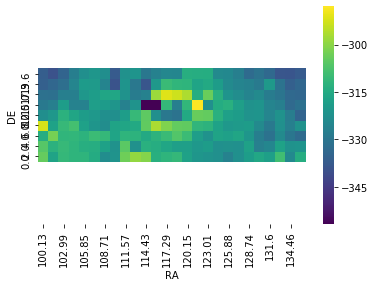

In [124]:
dataOO_rv=(dataOO.round(2)).pivot(index='DE', columns='RA', values='RV[OIII]5007')
sns.heatmap(dataOO_rv, cmap="viridis")
plt.gca().invert_yaxis()
plt.axis('equal')

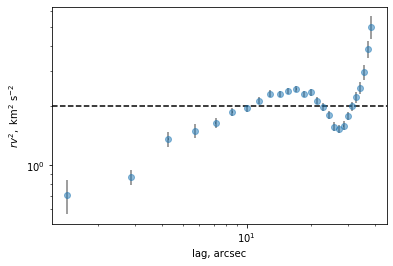

In [125]:
sfn_O2=sosfnorm(dataOOstat)

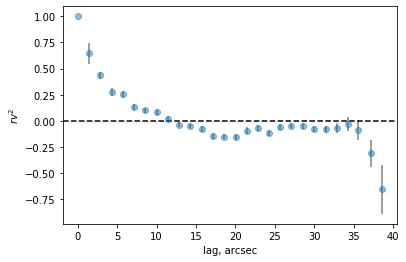

In [126]:
af_O2=acf(dataOOstat)

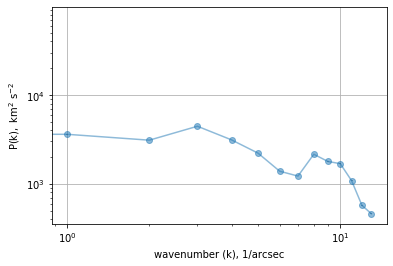

In [132]:
ps_O2=ps(dataOOstat)

Lines comparison

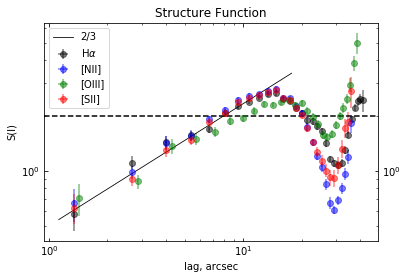

In [127]:
fig, ax=plt.subplots()
ax.errorbar(sfn_h3['Lag'],sfn_h3['Nmqvd'],xerr=sfn_h3.ErrX,yerr=sfn_h3.ErrY, fmt="o",color='k', ecolor='k', alpha=0.5, label=r'H$\alpha$')
ax.errorbar(sfn_n2['Lag'],sfn_n2['Nmqvd'],xerr=sfn_n2.ErrX,yerr=sfn_n2.ErrY, fmt="o",color='b', ecolor='b', alpha=0.5, label='[NII]')
ax.errorbar(sfn_O2['Lag'],sfn_O2['Nmqvd'],xerr=sfn_O2.ErrX,yerr=sfn_O2.ErrY, fmt="o",color='g', ecolor='g', alpha=0.5, label='[OIII]')
ax.errorbar(sfn_s2['Lag'],sfn_s2['Nmqvd'],xerr=sfn_s2.ErrX,yerr=sfn_s2.ErrY, fmt="o",color='r', ecolor='r', alpha=0.5, label='[SII]')
ax.set(xscale='log',yscale='log')
sgrid = np.logspace(.05, 1.25)
ax.plot(sgrid, 0.5*sgrid**(2/3), color="k", lw=0.8, label='2/3')
ax.axhline(y=2, color='k', linestyle='--')
ax.set(xlabel='lag, arcsec', ylabel='S(l)')
plt.title('Structure Function')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.legend(loc='upper left')

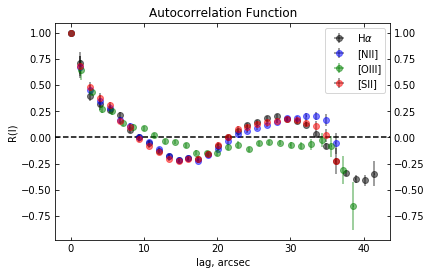

In [128]:
fig, ax=plt.subplots()
ax.errorbar(af_h3['Lag'],af_h3['Nmqvd'],xerr=af_h3.ErrX,yerr=af_h3.ErrY, fmt="o",color='k', ecolor='k', alpha=0.5,label=r'H$\alpha$')
ax.errorbar(af_n2['Lag'],af_n2['Nmqvd'],xerr=af_n2.ErrX,yerr=af_n2.ErrY, fmt="o",color='b', ecolor='k', alpha=0.5,label='[NII]')
ax.errorbar(af_O2['Lag'],af_O2['Nmqvd'],xerr=af_O2.ErrX,yerr=af_O2.ErrY, fmt="o",color='g', ecolor='g', alpha=0.5, label='[OIII]')
ax.errorbar(af_s2['Lag'],af_s2['Nmqvd'],xerr=af_s2.ErrX,yerr=af_s2.ErrY, fmt="o",color='r', ecolor='k', alpha=0.5,label='[SII]')
#x.set(xscale='log')
ax.axhline(y=0, color='k', linestyle='--')
ax.set(xlabel='lag, arcsec', ylabel='R(l)')
plt.title('Autocorrelation Function')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.legend()

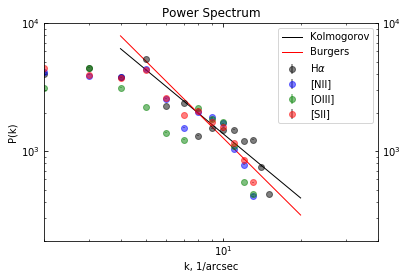

In [133]:
fig, ax=plt.subplots()
ax.errorbar(ps_h3['k'],ps_h3['P(k)'], yerr=ps_h3.ErrY, fmt="o",color='k', ecolor='k', alpha=0.5,label=r'H$\alpha$')
ax.errorbar(ps_n2['k'],ps_n2['P(k)'], yerr=ps_n2.ErrY, fmt="o",color='b', ecolor='k', alpha=0.5,label='[NII]')
ax.errorbar(ps_O2['k'],ps_O2['P(k)'], yerr=ps_O2.ErrY, fmt="o",color='g', ecolor='g', alpha=0.5, label='[OIII]')
ax.errorbar(ps_s2['k'],ps_s2['P(k)'], yerr=ps_s2.ErrY, fmt="o",color='r', ecolor='k', alpha=0.5,label='[SII]')
ax.set(xscale='log', yscale='log')
sgrid = np.logspace(0.6, 1.3)
plt.plot(sgrid, (10**4.8)*sgrid**(-5/3), color="k", lw=1, label="Kolmogorov")
plt.plot(sgrid, (10**5.1)*sgrid**(-2), color="r", lw=1, label="Burgers")
ax.set(xlabel='k, 1/arcsec', ylabel='P(k)')
plt.title('Power Spectrum')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
ax.set(xlim=[2, 40],ylim=[200, 10000])
plt.legend()